<a href="https://colab.research.google.com/github/cityofwalls/Star_Trek_Text_Gen/blob/master/Star_Trek_Text_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Picard Dialogue Generator
- Initial start date: 8/30/2019
- Completed: 9/4/2019
- Project data provided at https://www.kaggle.com/gjbroughton/start-trek-scripts by Gary Broughton
---
## Project Outline
- The data provided includes script contents from every aired episode of all Star Trek series.
- Pairing this down to The Next Generation (TNG), train a model to generate lines of dialogue in the style of Jean-Luc Picard.
- Initially, this model will produce dialoogue "in the ether", i.e. from noise breathes Picards words.
- However, advanced implementations of this model might be fine-tuned to produce Picard off of another character's prompt.
- A use-case for this model might involve interaction with Star Trek-themed accounts on Twitter, such as: RikerGoogling (https://twitter.com/RikerGoogling) and Worf Email (https://twitter.com/WorfEmail)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import json
import re
import numpy as np

In [0]:
PROJECT_PATH = 'drive/My Drive/Machine_Learning/Synapse_Interview/'
DATA_PATH = PROJECT_PATH + 'star_trek_data/'
RAW_DATA, LINES_DATA = DATA_PATH + 'all_scripts_raw.json', DATA_PATH + 'all_series_lines.json'
WEIGHTS_PATH = PROJECT_PATH + 'saved_weights/'

## Data Exploration
- Pull in json data (all_scripts_raw)
- Probe to find where character lines live
- Construct list of best Picard-heavy episodes
---
### References
- JSON: https://realpython.com/python-json/
- Episode selection ideas: https://screenrant.com/best-star-trek-tng-episodes/

In [5]:
with open(RAW_DATA, 'r') as f:
  data = json.load(f)
print('Top level of [data] tags:', [k for k, _ in data.items()])

Top level of [data] tags: ['DS9', 'TOS', 'TAS', 'TNG', 'VOY', 'ENT']


In [6]:
tng = data['TNG']
print('Tags at this level:', [k for k, _ in tng.items()])

Tags at this level: ['episode 0', 'episode 1', 'episode 2', 'episode 3', 'episode 4', 'episode 5', 'episode 6', 'episode 7', 'episode 8', 'episode 9', 'episode 10', 'episode 11', 'episode 12', 'episode 13', 'episode 14', 'episode 15', 'episode 16', 'episode 17', 'episode 18', 'episode 19', 'episode 20', 'episode 21', 'episode 22', 'episode 23', 'episode 24', 'episode 25', 'episode 26', 'episode 27', 'episode 28', 'episode 29', 'episode 30', 'episode 31', 'episode 32', 'episode 33', 'episode 34', 'episode 35', 'episode 36', 'episode 37', 'episode 38', 'episode 39', 'episode 40', 'episode 41', 'episode 42', 'episode 43', 'episode 44', 'episode 45', 'episode 46', 'episode 47', 'episode 48', 'episode 49', 'episode 50', 'episode 51', 'episode 52', 'episode 53', 'episode 54', 'episode 55', 'episode 56', 'episode 57', 'episode 58', 'episode 59', 'episode 60', 'episode 61', 'episode 62', 'episode 63', 'episode 64', 'episode 65', 'episode 66', 'episode 67', 'episode 68', 'episode 69', 'episode 

In [0]:
measure_of_a_man = tng['episode 33']
tapestry = tng['episode 139']
chain_of_command_1 = tng['episode 134']
chain_of_command_2 = tng['episode 135']
all_good_things = tng['episode 175']
inner_light = tng['episode 123']
i_borg = tng['episode 121']
darmok = tng['episode 100']
best_of_both_worlds_1 = tng['episode 72']
best_of_both_worlds_2 = tng['episode 73']
selected_episodes = [measure_of_a_man, tapestry, chain_of_command_1, chain_of_command_2, all_good_things, inner_light, i_borg, darmok, best_of_both_worlds_1, best_of_both_worlds_2]

## API for dialogue extraction
---
- <code>remove_stage_direction()</code>
  - Given a raw text/string of episode <code>script</code> find all text between '()' and '[]' as these are not dialogue
  - Returns the script without stage directions.
- <code>extract_conversations_from()</code>
  - Given an <code>episode</code> and two charcter names (in all caps) <code> character1, character2</code>, find all pairs of lines in which the first defined character speaks followed by the second.
  - Returns a list of lists of strings, where each inner list is an alternating sequence of lines by the first and second given characters.

In [0]:
def remove_stage_direction(script):
  pattern = re.compile(r'\(.*?\)', re.DOTALL)
  directions = re.findall(pattern, script)
  directions += re.findall(r'\s*\[.*\]', script)
  for d in directions:
    script = script.replace(d, '')
  return script

In [0]:
def extract_conversations_from(episode, character1='RIKER', character2='PICARD'):
  dialogue = remove_stage_direction(episode)
  dialogue = dialogue.split('\n')
  while '' in dialogue:
    dialogue.remove('')
  while ' ' in dialogue:
    dialogue.remove(' ')
  
  conversations = []
  other_character = "^[0]*'*[A-Z]+"
  last_attribution = ''
  for i in range(len(dialogue) - 8):
    if re.match(character1, dialogue[i]) and last_attribution != character1:
      last_attribution = character1
      conversations.append([dialogue[i]])
    elif re.match(character2, dialogue[i]) and last_attribution == character1:
      last_attribution = character2
      conversations[-1].append(dialogue[i])
    elif not (re.match(character1, dialogue[i]) or re.match(character2, dialogue[i])) and re.match(other_character, dialogue[i]):
      last_attribution = dialogue[i].split(':')[0]
      continue
    elif not re.match(other_character, dialogue[i]) and (last_attribution == character1 or last_attribution == character2):
      conversations[-1][-1] += ' ' + dialogue[i]

  # Remove single lines of dialogue since these are not conversations
  for c in reversed(conversations):
    if len(c) < 2:
      conversations.remove(c)

  return conversations

## Data Preprocessing API for RNN and GAN
---
### Conversations of 2 actors --> data
- <code>normalize()</code>
  - Given an <code>element</code> (single length string, or word) and <code>vocab</code> (complete vocabulary of feature set), map the element to a value between -1.0 and 1.0.
- <code>inverse_normalize()</code>
  - Given a floating point <code>value</code> between -1.0 <-> 1.0 and the appropriate <code>vocab</code>, transform the value into a single length string or word from that vocabulary. True inverse of above normalize function.
- <code>get_label()</code>
  - Given an <code>element</code> and <code>vocab</code>, form a probability numpy array. This label will be of shape (1, 1, len(vocab)) and will contain all 0.0s except for a 1.0 in a position of the array that corresponds to the position of the element within the vocab list.
- <code>get_noise()</code>
  - Returns a numpy array of random values between -1.0 and 1.0 from a normal distribution.
- <code>form_X_y_from()</code>
  - <i>Helper Function</i> for RNN functions. Given pairs of dialogue separated at some atomic level, forms input training sequences of length <code>input_dimension</code> with a single element as output.
- <code>convert_conversations_to_rnn_X_y()</code>
  - Lists of conversations between two given characters are formed into sequences of atomic elements to be used as training data for an RNN.

In [0]:
def normalize(element, vocab):
  return vocab.index(element)*2/(len(vocab) - 1) - 1

In [0]:
def inverse_normalize(value, vocab):
  return vocab[int((value + 1) * (len(vocab) - 1)/2)]

In [0]:
def get_label(element, vocab):
  label = np.zeros(len(vocab))
  label[vocab.index(element)] = 1.0
  return label

In [0]:
def get_noise(length):
  return np.random.normal(0.0, 0.265, (1, 1, length))

In [0]:
def form_X_y_from(initial, out_data, input_dimension, X, y):
  # Form input and output sequences using initial data and out_data
  for i in range(len(initial)):
    if i > (len(out_data) - 1):
      return
    inp = initial[i:] + out_data[:i]
    outp = out_data[i]
    X.append(inp)
    y.append(outp)

  # Finish up with out_data
  for i in range(len(out_data) - input_dimension):
    inp = out_data[i:i+input_dimension]
    outp = out_data[i+input_dimension]
    X.append(inp)
    y.append(outp)

In [0]:
def convert_conversations_to_rnn_X_y(conversations, character_level=True):
  # character_level -- atomic data orientation for conversations (binary):
  #   1) Character level (True): Treat each unique character (alpha-numeric, punctuation, and space) as a feature of the sequence
  #   2) Word level (False): Treat each complete word as a feature and punctuation as a separate feature of the sequence
  delimiter = r"[A-Z|'|a-z]|\s|,|\." if character_level else r"\w+'*-*\w*|\W*"
  character1, character2 = conversations[0][0][0].split(' ')[0] + ' ', conversations[0][0][1].split(' ')[0] + ' '

  prompt, response, vocab = [], [], set()
  for episode_convos in conversations:
    for convo in episode_convos:
      for i in range(1, len(convo), 2):
        line1 = re.findall(delimiter, convo[i-1][len(character1):])
        prompt.append(line1)
        line2 = re.findall(delimiter, convo[i][len(character2):])
        response.append(line2)
        for element in line1:
          vocab.add(element)
        for element in line2:
          vocab.add(element)
  
  input_dimension = 100 if character_level else 20
  X, y = [], []
  for i in range(len(prompt)):
    # Truncate inputs that are longer than input_dimension and pad the rest with ' '
    if len(prompt[i]) > input_dimension:
      initial_input = prompt[i][len(prompt[i])-input_dimension:]
    else:
      diff = input_dimension - len(prompt[i])
      initial_input = ([' '] * diff) + prompt[i]
    outp = response[i]
    form_X_y_from(initial_input, outp, input_dimension, X, y)

  vocab = sorted(list(vocab))
  if character_level:
    X = np.array([np.array([np.array([normalize(element, vocab) for element in X[i][j]]) for j in range(len(X[i]))]) for i in range(len(X))])
    y = np.array([np.array([get_label(element, vocab) for element in y[i]]) for i in range(len(y))])
  else:
    X = np.array([np.array([normalize(word, vocab) for word in X[i]]) for i in range(len(X))])
    y = np.array([get_label(element, vocab) for element in y])
  X = X.reshape(len(X), 1, input_dimension)
  y = y.reshape(len(y), 1, len(vocab))
  return X, y, vocab

## Recurrent Neural Network
---
### Character and Word level
- For the first pass at modeling conversation behavior, I'll work with an RNN.
- To find the best implementation for this type of model, it might be fruitful to try training and generating at both the character level and word level.
- In the past, I have had success generating from the character level, but it takes quite a bit of training to get there. It might be nice to compare this to a model operating at the word level.
---
### Methodology
- The methodology follows a typical training/testing phase: Split the training examples into 80/20 training and testing examples, train on the 80% and evaluate the model on the remaining 20%.
- While this isn't the most meaningful method of evaluation, it may provide some insight into the model's behavior during training and testing. In accuality, it will come down to the text that is generated to show how well the model is performing.
---
### Current Considerations
- For this type of model, extracting and processing all Riker and Picard conversations throughout TNG proved to be too large to fit into the 12GB of RAM Google Colab provides, so instead I will try smaller subsets of data and build up to a large, robust dataset. I may also use a batch forming subroutine to build training batches. 
- <s>For the early stages, I handpicked 10 episodes to extract Riker/Picard conversations from. Later, I will attempt incresing this to a full season (~26 episodes) or more.</s>
- EDIT (9/3/2019): In my data prepping for the RNN, I was appending extra space characters <b>(' ')</b> to the output sequences to fill a consistent length. This proved to effect the RNN's ability to predict, in addition to filling up RAM. I realized these space characters are not necessary and have since removed them. The entire series worth of conversation between Riker and Picard now fit in RAM :)
---
### Current Results
#### 9/1 - 9/2/2019
- With this small dataset run through a relatively small RNN, I find that the reported loss (calculated with categorical crossentropy) and accuracy is much more successful than I would have guessed (loss= 0.1314, acc= 0.9616), however when running on the test set, these metrics fall to 
  - Loss: 6.5113224260734786
  - Accuracy: 0.44886363636363635
- This shows that the model is overfitting to the small data set and is very poor at generalizing.
- To combat this, I will explore larger data sets and adjusting the drop_rate of Dropout layers in the RNN implementation. This regularization technique should help ensure all nodes in the model get time to train.

#### 9/3/2019
- Attempting a larger RNN (more hidden layers) and larger drop_rate (0.5)
- Increased data set to 40 episodes.
- After 100 epochs, loss and accuracy plateaued to 2.23 and 0.53 respectively.
- This ended up being far more consistent with the evaluation on the test set:
  - Loss: 3.9284179932129883
  - Accuracy: 0.5205410821643287
- Unfortunately, this means we have swung far back away from overfitting and might need to consider a few things to improve this model:
  - Loosen the drop_rate (0.3?)
  - Increase data set again (100 episodes?)
  - Adjust learning rate of optimzers -- So far have tried vanilla Adam and RMSprop, but will adjust their hyperparameters
- After playing with optimizers and their hyperparameters, it would seem Adam has a slight advantage over RMSprop if we cut the learning rate in half (default 0.001 -> 0.0005), in past projects, adjusting <code>beta_1</code> has helped, but keeping it at its default (0.9) appears to be best for this RNN.
- Made a slight edit to the formation of sequences to the RNN and now the entire data set fits into RAM... training on entire dataset.

In [16]:
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Dropout, Bidirectional, Activation, LeakyReLU, BatchNormalization, TimeDistributed
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
convos = []
for i in range(len(tng)):
  convos.append(extract_conversations_from(tng['episode ' + str(i)]))

In [0]:
# Reproducability
np.random.seed(7)

lstm_nodes  = 1024
dense_nodes = 256
drop_rate   = 0.3
epochs      = 20

# Adam | RMSprop
# optimizer = RMSprop(lr=0.001, rho=0.9,)
optimizer = Adam(lr=0.0005, beta_1=0.9,)

In [19]:
X, y, vocab = convert_conversations_to_rnn_X_y(convos, character_level=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(y.shape)
print(len(vocab))

(93997, 1, 100)
(93997, 1, 58)
58


In [0]:
# Dump vocab into file in order to generate from a loaded model
import pickle as pkl

with open(WEIGHTS_PATH + 'vocab.pkl', 'wb') as f:
  pkl.dump(vocab, f)

In [21]:
model = Sequential()

model.add(CuDNNLSTM(lstm_nodes, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))

model.add(Bidirectional(CuDNNLSTM(lstm_nodes, return_sequences=True)))
model.add(Dropout(drop_rate))

model.add(Bidirectional(CuDNNLSTM(lstm_nodes, return_sequences=True)))
model.add(Dropout(drop_rate))

model.add(Bidirectional(CuDNNLSTM(lstm_nodes//2, return_sequences=True)))
model.add(Dropout(drop_rate))

model.add(Bidirectional(CuDNNLSTM(lstm_nodes//2, return_sequences=True)))
model.add(Dropout(drop_rate))

model.add(TimeDistributed(Dense(dense_nodes)))
model.add(Dropout(drop_rate))

model.add(Dense(len(vocab)))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

W0905 03:49:04.310244 140124472878976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 03:49:04.316400 140124472878976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 03:49:05.759248 140124472878976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 03:49:16.100292 140124472878976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0905 03:49:16.112074 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1, 1024)           4612096   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 2048)           16793600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2048)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 2048)           25182208  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 2048)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1, 1024)           10493952  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1024)          

In [0]:
with open(WEIGHTS_PATH + 'vocab.pkl', 'rb') as f:
  vocab = pkl.load(f)
model.load_model(WEIGHTS_PATH + 'rnn/loss=0.25991-acc=0.92262-930_9-4-2019.hdf5')

In [24]:
d = datetime.now() - timedelta(hours=7)
date = '{}{}_{}-{}-{}'.format(d.hour, d.minute, d.month, d.day, d.year)
filepath = WEIGHTS_PATH + 'rnn/loss={loss:.5f}-acc={acc:.5f}-' + date + '.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=epochs, callbacks=callbacks_list, validation_data=(X_test, y_test))

Train on 75197 samples, validate on 18800 samples
Epoch 1/20
75197/75197 [==============================] - 330s 4ms/step - loss: 2.9461 - acc: 0.1882 - val_loss: 2.8730 - val_acc: 0.1974

Epoch 00001: loss improved from inf to 2.94611, saving model to drive/My Drive/Machine_Learning/Synapse_Interview/saved_weights/rnn/loss=2.94611-acc=0.18819-2050_9-4-2019.hdf5
Epoch 2/20
75197/75197 [==============================] - 329s 4ms/step - loss: 2.8422 - acc: 0.2002 - val_loss: 2.7971 - val_acc: 0.2057

Epoch 00002: loss improved from 2.94611 to 2.84220, saving model to drive/My Drive/Machine_Learning/Synapse_Interview/saved_weights/rnn/loss=2.84220-acc=0.20017-2050_9-4-2019.hdf5
Epoch 3/20
75197/75197 [==============================] - 329s 4ms/step - loss: 2.7654 - acc: 0.2158 - val_loss: 2.7043 - val_acc: 0.2349

Epoch 00003: loss improved from 2.84220 to 2.76541, saving model to drive/My Drive/Machine_Learning/Synapse_Interview/saved_weights/rnn/loss=2.76541-acc=0.21575-2050_9-4-2019.hd

In [25]:
metrics = model.evaluate(X_test, y_test)
print('Loss:', str(metrics[0]))
print('Accuracy:', str(metrics[1]))

18800/18800 [==============================] - 11s 580us/step
Loss: 2.2458249114422086
Accuracy: 0.37920212765957445


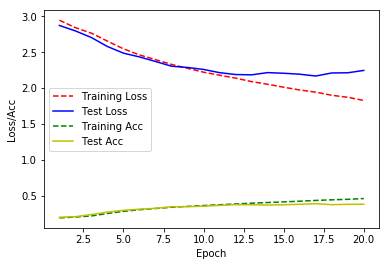

In [26]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
training_acc = history.history['acc']
test_acc = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.plot(epoch_count, training_acc, 'g--')
plt.plot(epoch_count, test_acc, 'y-')
plt.legend(['Training Loss', 'Test Loss', 'Training Acc', 'Test Acc'])
plt.xlabel('Epoch')
plt.ylabel('Loss/Acc')
plt.show();

In [0]:
from random import choice

def rnn_generate(rnn, vocab, input_dimension):
  sequence = ''
  inp = choice(X).reshape(1, X.shape[1], X.shape[2])
  for _ in range(input_dimension):
    y_hat = rnn.predict(inp, verbose=0)[0][0]
    y_hat = vocab[np.argmax(y_hat)]
    sequence += y_hat
    inp = np.append(inp[0][0][1:], [normalize(y_hat, vocab)]).reshape(1, 1, input_dimension)
  return sequence

In [0]:
seq = rnn_generate(model, vocab=vocab, input_dimension=100)
print(seq)

ich this shenal beacon was in gendral use. Hndeed. I Forge,and Seate you anmpcecked we worruer,ueadi


## RNN Conclusion
- Both training at character level and word level take a lot of time and given substantial training of each, I'm not thrilled by the results.
- In the past, I've had success training an RNN at the character level for ~150-200 epochs. This data set is of comparable size, so it is likely that the model could get there with more training.
- However, while monitoring loss during training, I noticed that the loss and accuracy of the training data sets progressed well, but these same metrics over the test set were quite poor. This leads me to believe that the model is continuing to overfit to the training data despite regularization. Perhaps, in addition to increasing drop_rate, exploring different sequence steps or smaller NNs could combat this problem. For now, I will leave this to future work.
- It is also difficult to train an RNN on noise, since the point of the model is to guess patterns that come after the input. For this reason, it might be useful to switch gears...

## GAN
---
### 9/4/2019
- To better represent the spirit of this project (generating text responses to given lines of text), I thought it would be interesting to construct and train a GAN.
- This will be a relatively simple GAN, but more complex ideas will be explored if I have time.
- For this implementation, we divide the data into a slightly alternate X and y from the RNN implementation...
  1. A generator will be trained to produce a line of text off of noise sampled from a normal distribution.
  2. The discriminator will be shown real Picard responses and fake responses produced by the generator. 
  3. The discriminator will be trained in tandem with the generator.
  4. The generator will be trained as part of a stacked model.
  5. Overall Structure: 
      - <i>NOISE</i>
      - } {} {} {} {
      - <b>GENERATOR</b>
      - } {} {} {} {
      - <i>TEXT RESPONSE</i>
      - } {} {} {} {
      - <b>DISCRIMINATOR</b>
      - } {} {} {} {
      - <i>VALIDITY</i>
  6. To generate text, we only need the the top sections of this stacked model -- the generator.

In [0]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Reshape, Activation, Bidirectional, TimeDistributed, CuDNNLSTM, Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint

In [0]:
def get_gan_label(real):
  label = np.random.normal(0.12, 0.03, (1, 1)) if not real else np.random.normal(1.0, 0.07, (1, 1))
  return label

In [0]:
def get_gan_noise(length):
  return np.random.normal(0.0, 0.265, (length,))

In [0]:
def convert_conversations_to_gan_X_y(conversations, input_dimension=100, character_level=True):
  # character_level -- atomic data orientation for conversations (binary):
  #   1) Character level (True): Treat each unique character (alpha-numeric, punctuation, and space) as a feature of the sequence
  #   2) Word level (False): Treat each complete word as a feature and punctuation as a separate feature of the sequence
  global response_length # We need to be able to see the length of the longest response outside of scope
  delimiter = r"[A-Z|'|a-z]|\s|,|\." if character_level else r"\w+'*-*\w*|\W*"
  char = conversations[0][0][1].split(' ')[0] + ' '

  X, y, vocab = [], [], set()
  for episode_convos in conversations:
    for convo in episode_convos:
      for i in range(1, len(convo), 2):
        X.append(get_noise(input_dimension))
        char_line = re.findall(delimiter, convo[i][len(char):])
        y.append(char_line)
        for element in char_line:
          vocab.add(element)
  
  longest_y = 0
  for i in range(len(y)):
    longest_y = len(y[i]) if len(y[i]) > longest_y else longest_y
    response_length = longest_y
  for i in range(len(y)):
    diff = longest_y - len(y[i])
    y[i] += [' '] * diff
  
  vocab = sorted(list(vocab))
  X = np.array(X).reshape(len(X), 1, input_dimension)
  y = np.array([np.array([normalize(element, vocab) for element in y[i]]) for i in range(len(y))]).reshape(len(y), 1, longest_y)
  return X, y, vocab

In [0]:
# The intention is to be able to feed the generator tweets as 'noise' (twitter.com/RikerGoogling)
input_dimension = 140

drop_rate = 0.3
gen_optimizer = Adam(lr=0.0001, beta_1=0.5)
disc_optimizer = Adam(lr=0.0001, beta_1=0.5) #SGD()

In [32]:
convos = []
for i in range(len(tng)):
  convos.append(extract_conversations_from(tng['episode ' + str(i)]))

X, y, vocab = convert_conversations_to_gan_X_y(convos, input_dimension=input_dimension, character_level=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(y.shape)
print(len(vocab))

(1460, 1, 140)
(1460, 1, 720)
58


In [0]:
def build_generator():
  model = Sequential()

  model.add(TimeDistributed(Dense(140, activation='relu', input_dim=input_dimension)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(TimeDistributed(Dense(256)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(TimeDistributed(Dense(512)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(TimeDistributed(Dense(1024)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(TimeDistributed(Dense(response_length, activation='tanh')))
  model.add(Reshape((1, response_length)))

  noise = Input(shape=(1, input_dimension))
  picard = model(noise)

  return Model(noise, picard)

In [0]:
def build_discriminator():
  model = Sequential()

  model.add(TimeDistributed(Dense(input_dimension, activation='relu', input_dim=response_length)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
  model.add(Dropout(drop_rate))

  model.add(Bidirectional(CuDNNLSTM(512, return_sequences=True)))
  model.add(Dropout(drop_rate))

  model.add(TimeDistributed(Dense(512)))
  model.add(Dropout(drop_rate))

  model.add(TimeDistributed(Dense(256)))
  model.add(Dropout(drop_rate))

  model.add(TimeDistributed(Dense(1)))
  model.add(Activation('softmax'))

  picard = Input(shape=(1, response_length))
  validity = model(picard)

  return Model(picard, validity)

In [0]:
def build_gan():
  generator = build_generator()
  discriminator = build_discriminator()

  generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  noise = Input(shape=(1, input_dimension))
  response = generator(noise)
  validity = discriminator(response)
  
  discriminator.trainable = False
  gan = Model(noise, validity)
  gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  discriminator.trainable = True
  discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)

  K.get_session().run(tf.global_variables_initializer())

  return generator, discriminator, gan

In [0]:
generator, discriminator, gan = build_gan()

In [0]:
def train_gan(epochs=10):
  num_train_ex = len(X_train)
  num_test_ex = len(X_test)
  for i in range(1, epochs + 1):
    print('----- MAIN EPOCH {} -----'.format(i))

    # Train discriminator on generated responses
    fake_labels = np.array([get_gan_label(False) for _ in range(num_train_ex)])
    fake_responses = generator.predict(X_train)
    d_loss_fake = discriminator.fit(fake_responses, fake_labels, epochs=1)
    d_loss_fake = d_loss_fake.history['loss'][-1]

    # Train discriminator on real responses
    real_labels = np.array([get_gan_label(True) for _ in range(num_train_ex)])
    d_loss_real = discriminator.fit(y_train, real_labels, epochs=1)
    d_loss_real = d_loss_real.history['loss'][-1]

    print('\nDiscriminator Loss: {:.4f}\n'.format((d_loss_fake + d_loss_real)*0.5))

    d = datetime.now() - timedelta(hours=7)
    date = '{}{}_{}-{}-{}'.format(str(d.hour).zfill(2), str(d.minute).zfill(2), str(d.month).zfill(2), str(d.day).zfill(2), d.year)
    filepath = WEIGHTS_PATH + 'gan/generator_weights-' + date + '-epoch={}.hdf5'.format(i)
    # checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, mode='min')
    # callbacks_list = [checkpoint]

    # Train generator within stacked gan
    gan.fit(X_train, real_labels, epochs=2, validation_data=(X_test, np.array([get_gan_label(True) for _ in range(num_test_ex)])))

    # Save current generator configuration
    generator.save(filepath)
    print()

In [0]:
train_gan(epochs=5000)

In [0]:
def gan_generate():
  response = ''
  noise = get_gan_noise(input_dimension).reshape(1, 1, input_dimension) # TODO: Replace with a bank of tweets that have been normalized
  y_hat = generator.predict(noise)[0][0]
  for i in range(len(y_hat)):
    response += inverse_normalize(y_hat[i], vocab)
  return response

In [59]:
generator = load_model(WEIGHTS_PATH + 'gan/generator_weights-2020_09-04-2019-epoch=3923.hdf5')
r = gan_generate()
print(r)

qZCkzkxvsD,Nj,FrrNzdnL FVYwfnIptAuLxvwuzDfXF'us,UjwnkZmaBf,sMC


## Conclusion
---
### Training
- Each training epoch consists of:
  1. Training the discriminator to recongize text streams produced by the generator.
  2. Training the discriminator on actual text responses from the data set.
  3. Training the generator twice in the stacked gan configuration.
- It's important to train the discriminator and generator in relatively equal amounts so that neither strays too far from the other. The effectiveness of generator training is dependent on the discriminator understanding the distribution of predictions of the generator, while also having the ability to fool the discriminator sometimes.
- In this project, I decided to train the generator twice, to see if this would allow for slightly more generated text responses slipping through. In hindsight, I'm not sure if this was a good idea as the more often the generator is called out, the more often its weights are adjusted through back-propagation.
- I noticed during training that the generator loss stayed pretty high and didn't move. This is mostly expected as it means that the discriminator is doing its job. Over time I would expect this loss to come down as the generator gets better and better at fooling the discriminator.
- I also took note of the discriminator's loss. It seems as though it would pick a 'safe' value (0.0 or 1.0) and stay there. This can be seen in the output:
  
<br>
------ MAIN EPOCH 794 -----
<br>
<br>
Epoch 1/1
<br>
1168/1168 [==============================] - 1s 1ms/step - loss: 14.0235
<br>
Epoch 1/1
<br>
1168/1168 [==============================] - 1s 1ms/step - loss: 0.0175
<br>
Discriminator Loss: 7.0205
<br>
<br>

- We can see that during the the first 'EPOCH 1/1' the loss of the discriminator is 14.023 and this is extremely high, but on the second 'Epoch 1/1' its extremely low (0.0175). The high loss was recorded on an epoch of fake data generated by the generator and the second was real examples. It would seem that the discriminator was locked into predicting close to 1.0 to everything and this could definitely effect generator training each epoch.
- I also implemented a bit of noise into the training labels (this idea came from https://github.com/soumith/ganhacks) and is meant to help with the problem of discriminator prediction locking. Guess this might take many thousands of epochs to ease out.
- I was able to train the GAN for 3923 epochs in Google Colab, and although this is quite a lot, it still falls short of typical gan training regimens which total somewhere on the scale of 15000 - 40000. I would like to see how something like this would do over that time and will explore this on a local machine in future work.
- The GAN setup I went with was simple:
  - <b>Generator:</b> a fully connected NN using <code>TimeDistributed</code> layer wrappers to allow them to integrate with LSTMs.
  - <b>Discriminator:</b> a substantially sized LSTM RNN using CUDA accelerated LSTM nodes and Bidirectional layer wrappers (which transform input sequence data into mirrored, bifuracted streams to allow the LSTMs better context by seeing sequences forwards and backwards.
- In the end, the GAN could not produce meaningful text (although I did run out of time for word level testing which will be saved for future work). However, with enough training, I am confident that the network would be able to produce responses in the style of Jean-Luc Picard.
- Another consideration is altering the generator and/or the discriminator. These will be explored in future work.
  - Adding LSTM layers into the generator.
  - Converting the generator or discrimintaor into a Convolutional Neural Network (CNN) could produce interesting results. I have had some luck with an implementation of a Deep Convolutional GAN (DCGAN) in another project, but it will require a lot of tweaking as it proved to be a little too complex for a single line of dialogue (as opposed to a full image).
  - More training, more data. The sad truth is we might fare better with more text to show the network. This could be done by extracting all Picard lines from the data set, instead of just the ones he gives immediately after Riker lines.